# Anomaly Detection: Signal Processing

We use time-frequency analysis techniques to time-series data and determine how best to isolate anomalies. Specifically, we employ wavelet decomposition to perform a multi-resolution analysis that effectively isolates both short and long-lived traffic anomalies. We extend this to the concept of a deviation score which considers signal variation in high and medium frequency bands. This score is effective at isolating anomalies and amenable for use in the generation of threshold-based alerts.

In [1]:
import pandas as pd
import pywt
import seaborn as sns
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Wavelets

As a mathematical tool, wavelets can be used to extract information from many different kinds of data, including audio signals, images and time-series. Sets of wavelets are generally needed to analyze data fully. A set of "complementary" wavelets will decompose data without gaps or overlap so that the decomposition process is mathematically reversible. Thus, sets of complementary wavelets are useful in wavelet based compression/decompression algorithms where it is desirable to recover the original information with minimal loss.

The wavelet transform is often compared with the Fourier transform, in which signals are represented as a sum of sinusoids. In fact, the Fourier transform can be viewed as a special case of the continuous wavelet transform with the choice of the mother wavelet ${\psi (t)=e^{-2\pi it}}$. Here is a plot of the Daubechies wave family "db5":

/home/anant/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


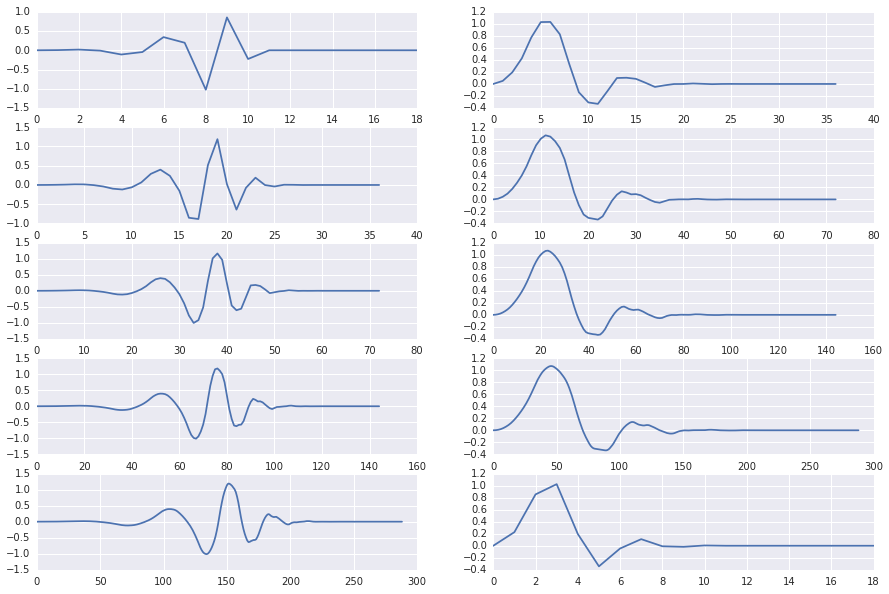

In [2]:
wave_family="db5"
wavelet = pywt.Wavelet(wave_family)
plt.figure(figsize=(15,10))
for i in range(5):
    phi, psi, x = wavelet.wavefun(level=i+1)
    plt.subplot(5,2,2*i)
    plt.plot(phi)
    plt.subplot(5,2,2*i+1)
    plt.plot(psi)

### Multi-Resolution Analysis

A multiresolution analysis (MRA) and modeling is the field of solving problems which have important features at multiple scales of time and/or space. In the context of time-series, this is composed of two coupled steps:

* Wavelet Decomposition generates wavelet coefficients at multiple time-resolutions
* Resynthesis of time-series from these coefficients into ['low','mid','high'] frequency bands

In [3]:
def synthesize(data,levels=None,wavelet=wavelet,BAND_high=3,BAND_mid=2):
    if not levels:
        levels = int(np.floor(np.log2(len(data))))
    coeffs = pywt.wavedec(data, wavelet, level=levels)
    use_levels_low = 1 + levels - BAND_high - BAND_mid
    use_levels_mid = 1 + levels - BAND_high
    NewWaveletCoeffs = {"low":[],"mid":[],"high":[]}
    for i in range(levels + 1):
        if (i < use_levels_low):
            NewWaveletCoeffs['low'].append(coeffs[i])
            tmparray = np.array([0.] * len(coeffs[i]))
            NewWaveletCoeffs['mid'].append(tmparray)
            NewWaveletCoeffs['high'].append(tmparray)
        elif (i < use_levels_mid):
            NewWaveletCoeffs['mid'].append(coeffs[i])
            tmparray = np.array([0.] * len(coeffs[i]))
            NewWaveletCoeffs['low'].append(tmparray)
            NewWaveletCoeffs['high'].append(tmparray)
        else:
            #coeffs[i] = 0
            NewWaveletCoeffs['high'].append(coeffs[i])
            tmparray = np.array([0.] * len(coeffs[i]))
            NewWaveletCoeffs['low'].append(tmparray)
            NewWaveletCoeffs['mid'].append(tmparray)
    for key in NewWaveletCoeffs.keys():
        NewWaveletCoeffs[key] = pd.Series(pywt.waverec(NewWaveletCoeffs[key],wavelet)[:len(data)],\
                                          index=data.index,name=key)
    return NewWaveletCoeffs

### Anomaly Detection

Severity scores are based on a weighted sum of the variance in a given time-window of the re-synthesised time-series at various time-resolutions. The window length as well as the weights are configurable but fixed parameters. Evaluation of deviation scores as a means for anomaly detection shows it to be similarly effective to sophisticated time-series techniques such as Holt-Winters Forecasting. Both techniques have a small set of tunable parameters, and can perform poorly if configured incorrectly or perform well if their parameters are configured appropriately.

In [4]:
def deviation_score(coefs,window_size=12,weights=[0.5,0.5]):
    coefs['mid'] = coefs['mid'].div(coefs['mid'].std())
    coefs['high'] = coefs['high'].div(coefs['high'].std())
    deviation = weights[0]*pd.rolling_var(coefs['mid'],window_size) + \
    weights[1]*pd.rolling_var(coefs['high'],window_size)
    deviation.name="deviation_score"
    return deviation

## Evaluation

We describe a visual analysis to evaluate the method on a subset of the time-series. The dataset for evaluating the methodology is comprised of SNMP router statistics (MIB) and network performance KPIs (delay, jitter etc) as a collection of time-series for the various network elements. The idea is to tune the parameters for optimal performance on the specific dataset. We intend to investigate how well the deviation score method can be implemented to detect anomalies in real time. Furthermore we should study methods for classifying anomalies which would facilitate their diagnosis and treatment. Finally, we also intend to pursue the idea of coordinated anomaly detection at multiple measurement locations in the wide area. 

In [5]:
files = os.listdir("data/Interface/")
interface = [pd.read_csv("data/Interface/%s"%vol,parse_dates=['time'],index_col=['time']).groupby(level="time").mean()\
             for vol in files]
interface = pd.concat(interface,axis=1)
if_dict = {"source":[],"type":[],"interface":[],"measure":[]}
for column in interface.columns:
    temp = column.split(" - ")
    if_dict['source'].append(temp[0][:-4])
    if_dict['type'].append(temp[0][-4:])
    if_dict['interface'].append(temp[1])
    if_dict['measure'].append(temp[2])

In [6]:
interface.columns = if_dict.values()
interface.columns.names = if_dict.keys()
interface = interface.resample("5 min",how=np.sum).sort_index(axis=1)
interface = interface.drop([col for col in interface.columns if interface[col].min() == interface[col].max()],axis=1)
interface = interface.dropna(axis=1,how="all")
interface.head(10)

interface                  Bundle-Ether1                        \
source                         AZUSCA218                         
type                                AW-C                         
measure             HC_Octets In (64Bit) HC_Octets Out (64Bit)   
time                                                             
2015-03-22 00:00:00          4522058.881          2.913138e+08   
2015-03-22 00:05:00          4242032.344          3.533884e+08   
2015-03-22 00:10:00          4419810.052          9.764718e+07   
2015-03-22 00:15:00          3500371.456          3.349261e+08   
2015-03-22 00:20:00          2339750.865          9.836566e+07   
2015-03-22 00:25:00          3200236.051          3.332810e+08   
2015-03-22 00:30:00          2542179.345          9.888853e+07   
2015-03-22 00:35:00          2509641.576          2.367707e+08   
2015-03-22 00:40:00          2225941.120          2.203034e+08   
2015-03-22 00:45:00          1964035.594          1.922584e+08   

interface                                                           \
source                                                               
type                                                          BW-C   
measure             _Interface Speed (64 Bit) HC_Octets In (64Bit)   
time                                                                 
2015-03-22 00:00:00               40000000000         1.155152e+08   
2015-03-22 00:05:00               20000000000         3.114473e+08   
2015-03-22 00:10:00               20000000000         1.382803e+08   
2015-03-22 00:15:00               20000000000         3.054351e+08   
2015-03-22 00:20:00               20000000000         1.345722e+08   
2015-03-22 00:25:00               20000000000         2.943311e+08   
2015-03-22 00:30:00               20000000000         1.382282e+08   
2015-03-22 00:35:00               20000000000         3.279284e+08   
2015-03-22 00:40:00               20000000000         1.009366e+08   
2015-03-22 00:45:00               20000000000         3.154237e+08   

interface                                                            \
source                                                                
type                                                                  
measure             HC_Octets Out (64Bit) _Interface Speed (64 Bit)   
time                                                                  
2015-03-22 00:00:00           1770902.668               20000000000   
2015-03-22 00:05:00           3847093.566               20000000000   
2015-03-22 00:10:00           4141615.274               20000000000   
2015-03-22 00:15:00           4207695.668               20000000000   
2015-03-22 00:20:00           2296989.095               20000000000   
2015-03-22 00:25:00           3227696.325               20000000000   
2015-03-22 00:30:00           2432545.951               20000000000   
2015-03-22 00:35:00           3348119.818               20000000000   
2015-03-22 00:40:00           1842162.326               20000000000   
2015-03-22 00:45:00           2554959.359               20000000000   

interface                                                       \
source                         CLSPCOYK8                         
type                                AW-C                         
measure             HC_Octets In (64Bit) HC_Octets Out (64Bit)   
time                                                             
2015-03-22 00:00:00          43925605.56           964487.4437   
2015-03-22 00:05:00          26049227.49           481542.1390   
2015-03-22 00:10:00          25755368.56           481820.0534   
2015-03-22 00:15:00          24941030.22           480741.8839   
2015-03-22 00:20:00          18388558.09           481991.8312   
2015-03-22 00:25:00          24405006.15           481357.0822   
2015-03-22 00:30:00          19133650.20           480786.8148   
2015-03-22 00:35:00          24471077.78           482270.8821   
2015-03-22 00:40:00          19051

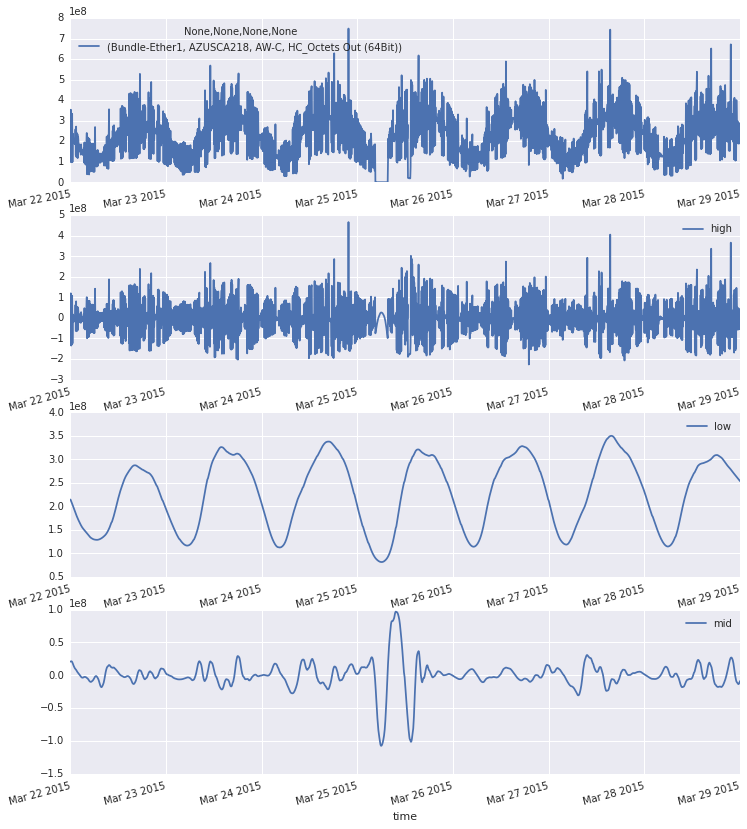

In [7]:
# wavelet decomposition and 3 level resynthesis into ['low','med','high'] bands
data=interface.iloc[:,1].dropna()
NewWaveletCoeffs = synthesize(data=data,wavelet=wavelet,BAND_high=4,BAND_mid=2)

# plot original data along with synthesised bands
fig,axes = plt.subplots(4,1,figsize=(12,15))
data.plot(ax=axes[0],rot=10,legend=True)
i=1
for band,coefs in NewWaveletCoeffs.items():
    coefs.plot(ax=axes[i],rot=15,legend=True)
    i+=1

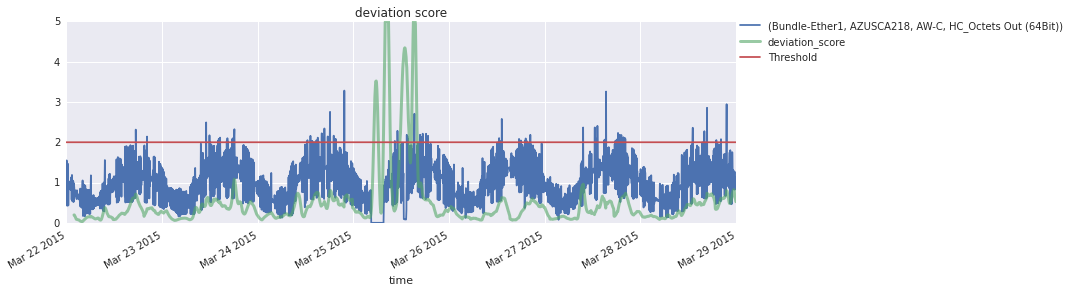

In [8]:
# calculate deviation score
deviation = deviation_score(NewWaveletCoeffs,window_size=24,weights=[0.75,0.25])

# plot deviation score
data.div(data.mean()).plot()
deviation.loc[deviation>5] = 5
deviation.plot(figsize=(12,4),title="deviation score",lw=3,alpha=0.6)
pd.Series([2]*len(data),index=data.index).plot(label="Threshold")
plt.legend(bbox_to_anchor=(1.5, 1.05))

In [9]:
brix = pd.read_csv("/mnt/dev/anant/NNO_POC/Sep15/NNJ_30_days_guavus_Brix.csv",parse_dates=[0])
dimensions = brix.columns[1:6].tolist()
for col in dimensions:
    print col, pd.unique(brix[col]).tolist()

SLA ['Northeast-NNJ-WSN', 'Northeast-NNJ-RAN']
Guaranteed Service ['TWAMP-Hub & Spoke']
Service Identifier ['WSNv4-DSCP46', 'WSNv4-DSCP32', 'RANv6-DSCP46', 'RANv6-DSCP32', 'WSNv4-DSCP0', 'RANv6-DSCP0']
Verifier ['BBTPNJDAMOB-A-BX-BRIX-01']
Responder ['BBTPNJ06MOA-A-BX-BRIX-02', 'BBTPNJ06MOA-A-BX-BRIX-01', 'JRCYNJ10MOA-A-BX-BRIX-02', 'WAYNNJAHMOA-A-BX-BRIX-02', 'WAYNNJAHMOA-A-BX-BRIX-01', 'JRCYNJ10MOA-A-BX-BRIX-01']


In [10]:
brix = brix.groupby(brix.columns[:6].tolist()).mean().unstack(dimensions)
brix.head()

Average Total Round-Trip Latency                           \
SLA                                Northeast-NNJ-RAN                            
Guaranteed Service                 TWAMP-Hub & Spoke                            
Service Identifier                       RANv6-DSCP0                            
Verifier                    BBTPNJDAMOB-A-BX-BRIX-01                            
Responder                   BBTPNJ06MOA-A-BX-BRIX-01 BBTPNJ06MOA-A-BX-BRIX-02   
Time                                                                            
2015-08-06 04:14:00                            408.0               389.900000   
2015-08-06 04:24:00                            413.5               394.000000   
2015-08-06 04:34:00                            403.5               394.666667   
2015-08-06 04:44:00                            402.0               384.800000   
2015-08-06 04:54:00                            405.4               390.300000   

                                                                       \
SLA                                                                     
Guaranteed Service                                                      
Service Identifier                                                      
Verifier                                                                
Responder           JRCYNJ10MOA-A-BX-BRIX-01 JRCYNJ10MOA-A-BX-BRIX-02   
Time                                                                    
2015-08-06 04:14:00              1446.555556              1453.444444   
2015-08-06 04:24:00              1452.700000              1451.636364   
2015-08-06 04:34:00              1445.800000              1448.444444   
2015-08-06 04:44:00              1445.000000              1449.700000   
2015-08-06 04:54:00              1437.700000              1453.100000   

                                                                       \
SLA                                                                     
Guaranteed Service                                                      
Service Identifier                                                      
Verifier                                                                
Responder           WAYNNJAHMOA-A-BX-BRIX-01 WAYNNJAHMOA-A-BX-BRIX-02   
Time                                                                    
2015-08-06 04:14:00              2003.100000              2000.400000   
2015-08-06 04:24:00              1999.400000              1996.200000   
2015-08-06 04:34:00              1996.300000              1999.888889   
2015-08-06 04:44:00              1999.222222              2004.090909   
2015-08-06 04:54:00              1998.900000              1993.888889   

                                                                       \
SLA                                                                     
Guaranteed Service                                                      
Service Identifier              RANv6-DSCP32                            
Verifier            BBTPNJDAMOB-A-BX-BRIX-01                            
Responder           BBTPNJ06MOA-A-BX-BRIX-01 BBTPNJ06MOA-A-BX-BRIX-02   
Time                                                                    
2015-08-06 04:14:00                    402.3               391.400000   
2015-08-06 04:24:00                    409.4               393.200000   
2015-08-06 04:34:00                    407.3               396.272727   
2015-08-06 04:44:00                    404.0               391.444444   
2015-08-06 04:54:00                    403.7               391.181818   

                                                                       \
SLA                                                                     
Guaranteed Service                                                      
Service Identifier                                                      
Verifier                                                                
Responder           JRCYNJ10MOA-A-BX-BRIX-01 JRCYNJ

In [11]:
set(brix.columns.get_level_values(0))

{'Average Total Round-Trip Latency',
 'Lost Packets',
 'Packets Received By Sender',
 'Packets Transmitted By Sender',
 'Reflector to Sender Average Jitter',
 'Sender to Reflector Average Jitter'}

Here is a visual representation of the multi-resolution analysis for an arbitrary time-series:

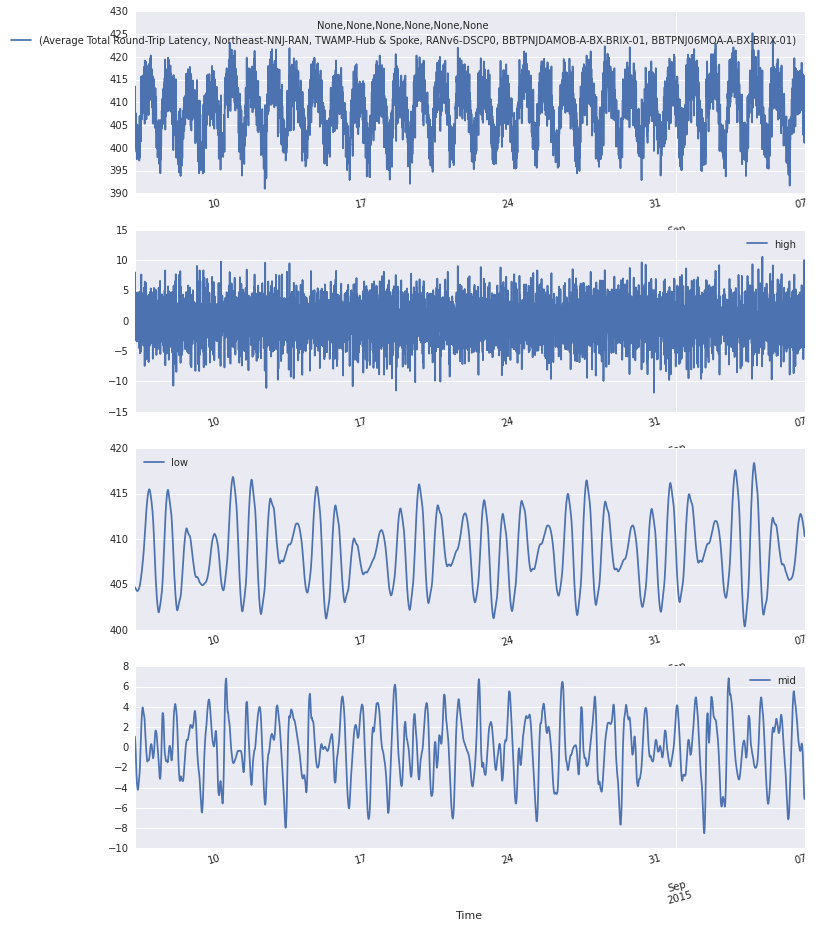

In [12]:
# wavelet decomposition and 3 level resynthesis into ['low','med','high'] bands
data=brix.xs('Average Total Round-Trip Latency',level=0,axis=1,drop_level=False).iloc[:,0].dropna()
NewWaveletCoeffs = synthesize(data=data,wavelet=wavelet,BAND_high=4,BAND_mid=2)

# plot original data along with synthesised bands
fig,axes = plt.subplots(4,1,figsize=(12,15))
data.plot(ax=axes[0],rot=10,legend=True)
i=1
for band,coefs in NewWaveletCoeffs.items():
    coefs.plot(ax=axes[i],rot=15,legend=True)
    i+=1

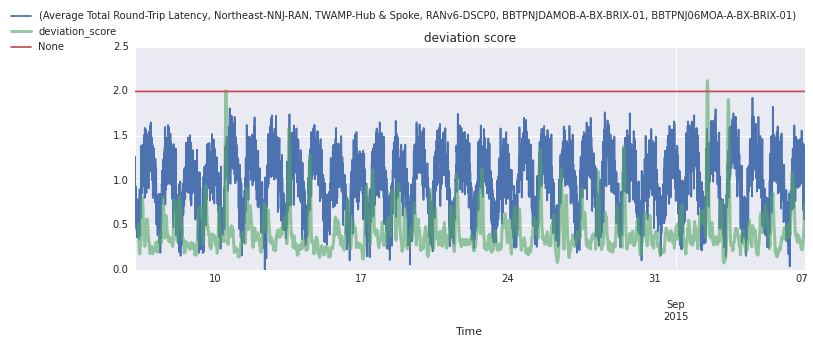

In [13]:
# calculate deviation score
deviation = deviation_score(NewWaveletCoeffs,window_size=24,weights=[0.75,0.25])

# plot deviation score
data.subtract(data.min()).div(3*data.std()).plot()
deviation.loc[deviation>5] = 5
deviation.plot(figsize=(12,4),title="deviation score",lw=3,alpha=0.6)
pd.Series([2]*len(data),index=data.index).plot()
plt.legend(bbox_to_anchor=(1.0, 1.2))

# References
* A Signal Analysis of Network Traffic Anomalies http://www.cs.cmu.edu/~srini/15-744/readings/BKPR02.pdf
* Wavelets https://en.wikipedia.org/wiki/Wavelet
* Multi-Resolution Analysis https://en.wikipedia.org/wiki/Multiscale_modeling